In [1]:
!pip install transformers

import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import re
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib as plt

from transformers import AutoTokenizer, TFBertModel, TFAutoModelForSequenceClassification
import shutil

# to use distilber TFBertModel
from transformers import BertTokenizer, BertConfig, TFDistilBertModel, DistilBertTokenizer, DistilBertConfig


# model
#from tensorflow.keras.optimizers import Adam  # computer version
from tensorflow.keras.optimizers.legacy import Adam # for colab
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, Dense

from sklearn.metrics import classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 22.6 MB/s eta 0:00:00


In [206]:
# Load dataset computer
#data = pd.read_csv("glassdoor_reviews_reshaped.csv", sep=',')

In [2]:
# Load dataset colab
from google.colab import drive 
drive.mount('/content/gdrive')

import pandas as pd 
data=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/glassdoor_reviews_reshaped.csv')

Mounted at /content/gdrive


In [3]:
data.shape

(1677132, 2)

In [4]:
# Reduced dataset size for testing

data, unused = train_test_split(data, random_state=42, train_size= 0.007, stratify=data.sentiment.values)

In [5]:
data.shape

(11739, 2)

<Axes: >

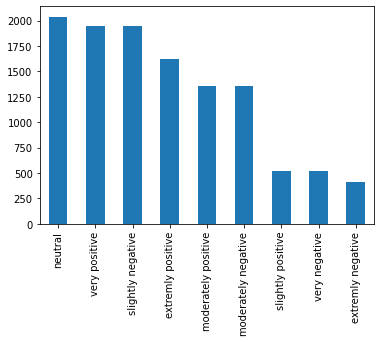

In [6]:
data['sentiment'].value_counts().plot(kind='bar')

#### Peprocessing dataset

In [7]:
# Data preparation

# Get column names for each data type
types_str = data.select_dtypes(include = 'object').columns
types_int = data.select_dtypes(include = [int,float]).columns

# Fill missing data
data[types_str] = data[types_str].fillna('NA')
#data[types_int] = SimpleImputer(strategy='mean').fit_transform(data[types_int])

# Drop duplicates
duplicate = data[['review']].duplicated()
data = data.loc[duplicate == False]
data = data.reset_index()
print('Drop duplicated:', duplicate.sum())

# Final frame
cols = ['review', 'sentiment']
df = data[cols]
df.fillna(' ',inplace=True)
df['review'].astype(str)
df['sentiment'].astype(str)

Drop duplicated: 57


<ipython-input-7-f39e9e1f49e7>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(' ',inplace=True)


0            very positive
1        slightly negative
2                  neutral
3            very positive
4                  neutral
               ...        
11677        very positive
11678    extremly positive
11679        very positive
11680        very positive
11681    slightly positive
Name: sentiment, Length: 11682, dtype: object

In [8]:
# Preprocessing text for transformation
def preprocess_text(document):
      # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))
        # remove all single characters
        #document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        # Remove single characters from the start
        #document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)
        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        ## Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)
        # Converting to Lowercase
        document = document.lower()
        return document

In [9]:
df_cleaned = data[['review']].applymap(lambda x: preprocess_text(x))

In [10]:
df_cleaned.head(3)

,review
0,flexible work schedule and great people to wor...
1,part a big corporate company with lots of syst...
2,people abuse it inconsistent management


In [11]:
df_cleaned['num_words'] = df_cleaned.review.apply(lambda x:len(x.split()))

467


<Axes: title={'center': 'Sentece length distribution'}, ylabel='Frequency'>

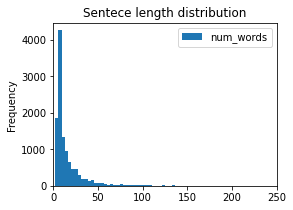

In [12]:
# No of words in semtence
filtered_df = df_cleaned[df_cleaned['num_words'] < 512]
print(max(filtered_df.num_words))
filtered_df.plot(kind='hist', title= 'Sentece length distribution', xlim= [0,250], figsize=(4,3), bins=128)

In [13]:
# Labels 
# convert labels to numbers
df_cleaned['sentiment'] = df.sentiment.astype('category')

#print(df_cleaned.info())
#print(df_cleaned.sentiment.unique())

In [14]:
encoded_dict = {'extremly negative':0, 'extremly positive':1, 'moderately negative':2, 'moderately positive':3, 'neurtral':4,
                        'slightly negative':5,'slightly positive':6,'very negative':7,'very positive':8}

df_cleaned['sentiment'] = df_cleaned.sentiment.cat.codes

#df_cleaned.head(4)

<Axes: >

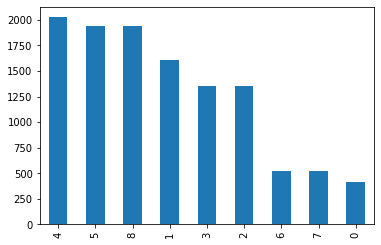

In [15]:
df_cleaned['sentiment'].value_counts().plot(kind='bar')

In [16]:
# Convert sentiment to one hot encoding
labels = to_categorical(df_cleaned.sentiment) # one hot ecooding

# Conveet labels to list
lables = labels.tolist()

#### Split into training, testing and validation dataset

In [17]:
# Devite into training, testing and validation dataset

# stratify based on "sentiment" column values
train_df, remaining = train_test_split(df_cleaned, random_state=42, train_size= 0.7, stratify=df_cleaned.sentiment.values)

valid_df , test_df = train_test_split(remaining, random_state=42, train_size= 0.5, stratify=remaining.sentiment.values)

df_cleaned.shape, train_df.shape, valid_df.shape, test_df.shape

((11682, 3), (8177, 3), (1752, 3), (1753, 3))

##### Tokenizing data and transforming to tensorflow dataset

In [18]:
# Encode text data into Bert input format
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

# Model has to be the same type
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=9)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# To use model localy we have to save 
tokenizer.save_pretrained('bert_tokenizer_auto')
model.save_pretrained('bert_model_auto')

In [20]:
shutil.make_archive('bert_tokenizer_auto', 'zip', 'bert_tokenizer_auto')
shutil.make_archive('bert_model_auto', 'zip', 'bert_model_auto')

'/content/bert_model_auto.zip'

In [21]:
# Test if tokenizer works
tokenizer('hellow world')

{'input_ids': [101, 19082, 2246, 1362, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [22]:
SENTENCE_LENGTH = 70

In [23]:
# Tokenize the input
def tokenize_data(df, sentence_length):
    x_tokenized  = tokenizer(
        text = df['review'].tolist(), #transform length
        add_special_tokens=True,
        max_length=sentence_length, # length of sentece
        truncation=True, # if sentence has 100 words it will be reduced to 70
        padding='max_length', # if has sentence has 35 words it will padd it until length 70
        return_tensors= 'tf',       #tokenizer will reutn tensorflow tensor
        return_token_type_ids= False,  # they are all 0 in this usecase
        return_attention_mask= True,
        verbose=True
        )
    return x_tokenized

In [24]:
x_train_tokenized = tokenize_data(train_df, sentence_length = SENTENCE_LENGTH)
x_valid_tokenized = tokenize_data(valid_df, sentence_length = SENTENCE_LENGTH)
x_test_tokenized = tokenize_data(test_df, sentence_length = SENTENCE_LENGTH)

In [25]:
# Labels (sentiment)

# Convert sentiment to one hot encoding
label_train = to_categorical(train_df['sentiment']) 
label_valid = to_categorical(valid_df['sentiment'])
label_test = to_categorical(test_df['sentiment'])

# Conveet labels to list
label_train = label_train.tolist()
label_valid = label_valid.tolist()
label_test = label_test.tolist()

In [26]:
# Convert to tensorflow dataset

with tf.device('/cpu:0'):
    dataset_train = tf.data.Dataset.from_tensor_slices((x_train_tokenized['input_ids'], x_train_tokenized['attention_mask'], label_train))
    dataset_valid = tf.data.Dataset.from_tensor_slices((x_valid_tokenized['input_ids'], x_valid_tokenized['attention_mask'], label_valid))
    dataset_test = tf.data.Dataset.from_tensor_slices((x_test_tokenized['input_ids'], x_test_tokenized['attention_mask'], label_test))


In [27]:
# Check how dataset looks
for input_ids, attention_mask, label in dataset_train.take(1):
    print("inpyt ids: ", input_ids)
    print("attention_mask: ", attention_mask)
    print("label: ", label)

inpyt ids:  tf.Tensor(
[  101  1822  2653 10326  1304  6214   102     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0], shape=(70,), dtype=int32)
attention_mask:  tf.Tensor(
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(70,), dtype=int32)
label:  tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(9,), dtype=float32)


In [28]:
# Map fucntion - define how will model return the outpoot
def map_to_dict(input_ids, attention_mask, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
    }, labels

In [29]:
# Map function - define how the model will retun the outpou
training_dataset =  dataset_train.map(map_to_dict)
validation_dataset = dataset_valid.map(map_to_dict)
test_dataset  = dataset_test.map(map_to_dict)

In [30]:
# batch adn shuffel datasets
BATCH_SIZE = 8
training_dataset = training_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

In [31]:
#model.layers
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True)

In [32]:
"""optimizer = Adam(
    learning_rate= 5e-05, # learning rate fro bert from huggingface website
    epsilon=1e-08,
    decay = 0.01,
    clipnorm = 1.0
)"""

# Set loss and matrices
#loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
#metric = CategoricalAccuracy('accuracy')
#loss = CategoricalCrossentropy(from_logits=True)
#metric = CategoricalAccuracy('balanced_accuracy')

# Compile a model
model.compile(
    optimizer = Adam(learning_rate=3e-5),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [33]:

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,
                              patience=1, verbose=1)

earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=3, #5
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

### model fitting and evaluation

In [34]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [36]:
"""train_history = model.fit(training_dataset,
    validation_data = validation_dataset,
    epochs=5,
    batch_size=128
)"""

train_history = model.fit(training_dataset,
                          validation_data = validation_dataset,
                          batch_size= BATCH_SIZE,
                          callbacks = [reduce_lr, earlyStopping], 
                          epochs = 20)

Epoch 1/20
1022/1022 [==============================] - 630s 617ms/step - loss: 1.3938 - accuracy: 0.4052 - val_loss: 1.4169 - val_accuracy: 0.3916 - lr: 3.0000e-05
Epoch 2/20
1022/1022 [==============================] - 626s 612ms/step - loss: 1.2369 - accuracy: 0.4631 - val_loss: 1.4142 - val_accuracy: 0.3973 - lr: 3.0000e-05
Epoch 3/20
1022/1022 [==============================] - ETA: 0s - loss: 1.0591 - accuracy: 0.5483
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-07.
1022/1022 [==============================] - 622s 609ms/step - loss: 1.0591 - accuracy: 0.5483 - val_loss: 1.5720 - val_accuracy: 0.3813 - lr: 3.0000e-05
Epoch 4/20
1022/1022 [==============================] - ETA: 0s - loss: 0.8136 - accuracy: 0.6952
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999998218954716e-09.
1022/1022 [==============================] - 626s 612ms/step - loss: 0.8136 - accuracy: 0.6952 - val_loss: 1.5474 - val_accuracy: 0.3807 - lr: 3.0000e-07
Epoch 5/20
1

In [37]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

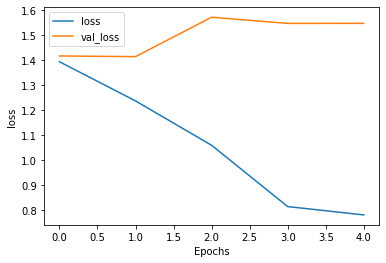

In [38]:
plot_graphs(train_history, 'loss')

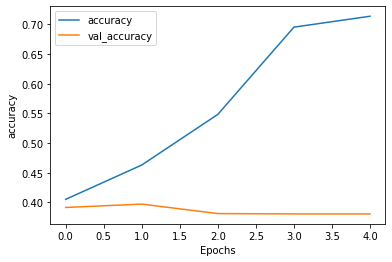

In [39]:
plot_graphs(train_history, 'accuracy')

#### save weights of the new trained model

In [ ]:
# model.save_weights('sentiment_weights.h5')

In [ ]:
# load weighets 
# model.load_weights('sentiment_weights.h5')

In [ ]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'], 'attention_mask':x_test['attention_mask']})

In [ ]:
# retuns values for each category
predicted_raw[0]

In [ ]:
y_predicted = np.argmax(predicted_raw, axis = 1)

In [ ]:
data_test.overall_rating

In [ ]:
print(classification_report(data_test.overall_rating, y_predicted))